### Log Anomlay Detector Core Mininimal Implementation

In an effort to help new users and contributors understand the core Machine Learning elements of the log anomaly detector I have decided to recreate a streamlined minimal version. Here we will ignore any streaming or external aspect of our data and use a fixed local data file for simplicity and reproducability.   

This notebook will cover:
* Log Preprocessing
* Text Encoding
* Model Training
* Generating Anomlay Scores
* Model Inference /Prediction

For the most part function names have been made to match their relevent counter part in the larger code base.

My aim for this notebook is that, by the end a reader will 1) have a clear understanding of how the current implementation works and 2) know where to make changes to try another approach. 

### Import our packages

In [2]:
import os
import time
import numpy as np
import logging
import sompy
from multiprocessing import Pool
from itertools import product
import pandas as pd
import re
import gensim as gs
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine
from sklearn.preprocessing import normalize

import matplotlib.pyplot as plt


CACHEDIR=/home/nadzya/.cache/matplotlib
Using fontManager instance from /home/nadzya/.cache/matplotlib/fontlist-v330.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
NumExpr defaulting to 4 threads.


### Define our Functions

#### 1. Log Preprocesing

One assumption that all these functions use is that we instantly convert our data into a pandas dataframe that has a "message" column containing the relevent information for us. 

We then treat each individual log line as a "word", cleaning it by removing all non-alphabet charcters including white spaces. 

In [3]:
def _preprocess(data):
    for col in data.columns:
        if col == "message":
            data[col] = data[col].apply(_clean_message)
        else:
            data[col] = data[col].apply(to_str)

    data = data.fillna("EMPTY")
    
def _clean_message(line):
    """Remove all none alphabetical characters from message strings."""
    return "".join(
        re.findall("[a-zA-Z]+", line)
    )  # Leaving only a-z in there as numbers add to anomalousness quite a bit

def to_str(x):
    """Convert all non-str lists to string lists for Word2Vec."""
    ret = " ".join([str(y) for y in x]) if isinstance(x, list) else str(x)
    return ret

#### 2. Text Encoding  

Here we employ the gensim implementation of Word2Vec to encode our logs as fixed length numerical vectors. Logs are noteably not the natural usecase for word2vec, but this appraoch attemps to leverage the fact that logs lines themselves, like words, have a context, so encoding a log based on its co-occurence with other logs does make some intuitive sense.

In [4]:
def create(words, vector_length, window_size):
    """Create new word2vec model."""
    w2vmodel = {}
    for col in words.columns:
        if col in words:
            w2vmodel[col] = gs.models.Word2Vec([list(words[col])], min_count=1, size=vector_length, 
                                     window=window_size, seed=42, workers=1, iter=550,sg=0)
        else:
            #_LOGGER.warning("Skipping key %s as it does not exist in 'words'" % col)
            pass
        
    return w2vmodel

def one_vector(new_D, w2vmodel):
    """Create a single vector from model."""
    transforms = {}
    for col in w2vmodel.keys():
        if col in new_D:
            transforms[col] = w2vmodel[col].wv[new_D[col]]

    new_data = []

    for i in range(len(transforms["message"])):
        logc = np.array(0)
        for _, c in transforms.items():
            if c.item(i):
                logc = np.append(logc, c[i])
            else:
                logc = np.append(logc, [0, 0, 0, 0, 0])
        new_data.append(logc)

    return np.array(new_data, ndmin=2)


#### 3. Model Training

Here we employ the SOMPY implementation of the Self-Organizing Map to train our model. This function simply makes it a bit easier for the user to interact with the sompy training requirements. This function returns a trained model.

The trained model object also has a method called codebook.matrix() which allows the user access directly to the trained self organizing map itself. If the map successfull converged then it should consist of nodes in our N-dimensional log space that are well ordered and provide an approximation to the topology of the logs in our training set.

During training we also, compute the distances of our training data to the trained map as a baseline to build a threashold.   

In [5]:
def train(inp, map_size, iterations, parallelism):
    print(f'training dataset is of size {inp.shape[0]}')
    mapsize = [map_size, map_size]
    np.random.seed(42)
    som = sompy.SOMFactory.build(inp, mapsize , initialization='random')
    som.train(n_job=parallelism, train_rough_len=100,train_finetune_len=5)
    model = som.codebook.matrix.reshape([map_size, map_size, inp.shape[1]])
    
    #distances = get_anomaly_score(inp, 8, model)
    #threshold = 3*np.std(distances) + np.mean(distances)
    
    return som #,threshold

#### 4. Generating Anomaly Scores

One of the key elements of this approach is quantifying the distance between our logs and the nodes on our self organizing map. The two functions below, taken together, represent a parrallel implementation for performing this calculaton.  

In [6]:
import sys
sys.path.append('/home/nadzya/Apps/log-anomaly-detector/')

In [7]:
def get_anomaly_score(logs, parallelism, model):

    parameters = [[x,model] for x in logs]
    pool = Pool(parallelism)
    dist = pool.map(calculate_anomaly_score, parameters) 
    pool.close()
    pool.join()
    #dist = [] 
    #for log in logs:
    #    dist.append(calculate_anomaly_score(log,model))
    
    return dist

def calculate_anomaly_score(parameters):
    log = parameters[0]
    model = parameters[1]
    """Compute a distance of a log entry to elements of SOM."""
    dist_smallest = np.inf
    for x in range(model.shape[0]):
        for y in range(model.shape[1]):
            dist = cosine(model[x][y],log) 
            #dist = np.linalg.norm(model[x][y] - log)
            if dist < dist_smallest:
                dist_smallest = dist
    return dist_smallest


#### 5. Model Inference / Prediction

Here we are making an inference about a new log message. This is done by scoring the incoming log and evaluating whether or not it passess a certain threshold value.  


Ideally our word2vec has been monitoring our application long enough to have seen all the logs. So, if we get a known log we can simply look up its vector representation   

One downside with word2vec is that its quite brittle when it comes to incorporating words that haven't been seen before. In this example, we will retrain the W2Vmodel if our new log has not been seen by the before.  

In [8]:
def infer(w2v, som, log, data, threshold):
    
    log =  pd.DataFrame({"message":log},index=[1])
    _preprocess(log)
    
    if log.message.iloc[0] in list(w2v['message'].wv.vocab.keys()):
        vector = w2v["message"].wv[log.message.iloc[0]]
    else:
        w2v = gs.models.Word2Vec([[log.message.iloc[0]] + list(data["message"])], 
                                 min_count=1, size=100, window=3, seed=42, workers=1, iter=550, sg=0)
        vector = w2v.wv[log.message.iloc[0]]
    
    score = get_anomaly_score([vector], 1, som)
    
    if score < threshold:
        return 0, score
    else:
        return 1, score


### Implementation

First we read in our test dataset and preprocesses. Here was can see this is a rather small example, with 10,000 log lines, but only 3 unique log messages

In [9]:
data_path = r"file:///home/nadzya/Apps/log-anomaly-detector/validation_data/log_anomaly_detector-10000-events.json"

In [10]:
data = pd.read_json(data_path, orient=str)

In [21]:
_preprocess(data)
data.head()

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages


In [22]:
data.tail()

,message
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages
9999,DEBUGProcessedoutofpackages


In [23]:
x = data.message.value_counts()
for i in x.keys():
    print(i, x[i])

DEBUGProcessedoutofpackages 9786
ThreadodcsserverINFOComposetypestatedoneComposedone 213
rootCMDusrlocalbinmonitorapachestatsshdevnull 1


In [24]:
data

,message
0,DEBUGProcessedoutofpackages
1,DEBUGProcessedoutofpackages
2,DEBUGProcessedoutofpackages
3,DEBUGProcessedoutofpackages
4,DEBUGProcessedoutofpackages
...,...
9995,DEBUGProcessedoutofpackages
9996,DEBUGProcessedoutofpackages
9997,DEBUGProcessedoutofpackages
9998,DEBUGProcessedoutofpackages


#### Encode our logs

We then create our w2vmodel based on our preprocessed dataset and replace our log lines with thier vectorized representation. 

In [25]:
w2vmodel = create(data, 100,3)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 3 word types from a corpus of 10000 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 3 unique words (100% of original 3, drops 0)
effective_min_count=1 leaves 10000 word corpus (100% of original 10000, drops 0)
deleting the raw counts dictionary of 3 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 379 word corpus (3.8% of prior 10000)
estimated required memory for 3 words and 100 dimensions: 3900 bytes
resetting layer weights
training model with 1 workers on 3 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10000 raw words (377 effective words) took 0.0s, 51318 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 35 : training on 10000 raw words (366 effective words) took 0.0s, 42948 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 36 : training on 10000 raw words (354 effective words) took 0.0s, 49908 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 37 : training on 10000 raw words (381 effective words) took 0.0s, 107195 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 38 : training on 10000 raw words (378 effective words) took 0.0s, 76601 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threa

worker thread finished; awaiting finish of 0 more threads
EPOCH - 72 : training on 10000 raw words (376 effective words) took 0.0s, 47924 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 73 : training on 10000 raw words (395 effective words) took 0.0s, 53802 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 74 : training on 10000 raw words (349 effective words) took 0.0s, 21897 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 75 : training on 10000 raw words (381 effective words) took 0.0s, 51271 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 76 : training on 10000 raw words (366 effective words)

EPOCH - 109 : training on 10000 raw words (354 effective words) took 0.0s, 83125 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 110 : training on 10000 raw words (403 effective words) took 0.0s, 34849 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 111 : training on 10000 raw words (384 effective words) took 0.0s, 39137 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 112 : training on 10000 raw words (365 effective words) took 0.0s, 73933 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 113 : training on 10000 raw words (400 effective words) took 0.0s, 105607 effective words/s
job loop exiting

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 147 : training on 10000 raw words (401 effective words) took 0.0s, 89659 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 148 : training on 10000 raw words (364 effective words) took 0.0s, 44216 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 149 : training on 10000 raw words (361 effective words) took 0.0s, 74272 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 150 : training on 10000 raw words (400 effective words) took 0.0s, 73019 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 184 : training on 10000 raw words (378 effective words) took 0.0s, 29530 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 185 : training on 10000 raw words (383 effective words) took 0.0s, 70192 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 186 : training on 10000 raw words (416 effective words) took 0.0s, 158838 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 187 : training on 10000 raw words (373 effective words) took 0.0s, 36556 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 188 : training o

worker thread finished; awaiting finish of 0 more threads
EPOCH - 221 : training on 10000 raw words (394 effective words) took 0.0s, 31034 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 222 : training on 10000 raw words (386 effective words) took 0.0s, 50080 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 223 : training on 10000 raw words (407 effective words) took 0.0s, 43066 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 224 : training on 10000 raw words (355 effective words) took 0.0s, 80620 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 225 : training on 10000 raw words (360 effective w

EPOCH - 258 : training on 10000 raw words (378 effective words) took 0.0s, 85283 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10000 raw words (371 effective words) took 0.0s, 77718 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10000 raw words (370 effective words) took 0.0s, 81152 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10000 raw words (396 effective words) took 0.0s, 56874 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10000 raw words (397 effective words) took 0.0s, 88190 effective words/s
job loop exiting,

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 296 : training on 10000 raw words (380 effective words) took 0.0s, 38670 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 297 : training on 10000 raw words (382 effective words) took 0.0s, 99662 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 298 : training on 10000 raw words (383 effective words) took 0.0s, 81496 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 299 : training on 10000 raw words (379 effective words) took 0.0s, 46626 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more th

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 333 : training on 10000 raw words (370 effective words) took 0.0s, 40342 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 334 : training on 10000 raw words (389 effective words) took 0.0s, 42956 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 335 : training on 10000 raw words (412 effective words) took 0.0s, 95220 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 336 : training on 10000 raw words (358 effective words) took 0.0s, 91654 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 337 : training on

worker thread finished; awaiting finish of 0 more threads
EPOCH - 370 : training on 10000 raw words (348 effective words) took 0.0s, 72046 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 371 : training on 10000 raw words (353 effective words) took 0.0s, 41723 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 372 : training on 10000 raw words (393 effective words) took 0.0s, 91960 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 373 : training on 10000 raw words (379 effective words) took 0.0s, 32414 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 374 : training on 10000 raw words (370 effective w

EPOCH - 407 : training on 10000 raw words (372 effective words) took 0.0s, 39545 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 408 : training on 10000 raw words (383 effective words) took 0.0s, 26114 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 409 : training on 10000 raw words (379 effective words) took 0.0s, 37294 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 410 : training on 10000 raw words (375 effective words) took 0.0s, 75842 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 411 : training on 10000 raw words (385 effective words) took 0.0s, 46295 effective words/s
job loop exiting,

job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 445 : training on 10000 raw words (378 effective words) took 0.0s, 137325 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 446 : training on 10000 raw words (396 effective words) took 0.0s, 76267 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 447 : training on 10000 raw words (376 effective words) took 0.0s, 77528 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 448 : training on 10000 raw words (394 effective words) took 0.0s, 30015 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more t

worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 482 : training on 10000 raw words (370 effective words) took 0.0s, 40604 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 483 : training on 10000 raw words (387 effective words) took 0.0s, 30579 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 484 : training on 10000 raw words (412 effective words) took 0.0s, 43129 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 485 : training on 10000 raw words (387 effective words) took 0.0s, 77527 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 486 : training on

worker thread finished; awaiting finish of 0 more threads
EPOCH - 519 : training on 10000 raw words (381 effective words) took 0.0s, 94538 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 520 : training on 10000 raw words (351 effective words) took 0.0s, 73694 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10000 raw words (369 effective words) took 0.0s, 96092 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10000 raw words (398 effective words) took 0.0s, 39314 effective words/s
job loop exiting, total 1 jobs
worker exiting, processed 1 jobs
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10000 raw words (363 effective w

In [26]:
transformed_data = one_vector(data, w2vmodel)
transformed_data = transformed_data[:,1:]

#### Train SOM

Here we train the Self Organizing Map on our vectorized logs and output a few vizualiztions of the trained model

In [37]:
map_size = 16
model = train(transformed_data, map_size, 0, 2)

 Training...
 random_initialization took: 0.005000 seconds
 Rough training...
 radius_ini: 6.000000 , radius_final: 1.000000, trainlen: 100

 epoch: 1 ---> elapsed time:  0.114000, quantization error: 34.573095



training dataset is of size 10000


 epoch: 2 ---> elapsed time:  0.151000, quantization error: 1.309813

 epoch: 3 ---> elapsed time:  0.096000, quantization error: 0.119531

 epoch: 4 ---> elapsed time:  0.117000, quantization error: 0.106123

 epoch: 5 ---> elapsed time:  0.114000, quantization error: 0.096062

 epoch: 6 ---> elapsed time:  0.119000, quantization error: 0.086719

 epoch: 7 ---> elapsed time:  0.127000, quantization error: 0.078077

 epoch: 8 ---> elapsed time:  0.120000, quantization error: 0.070114

 epoch: 9 ---> elapsed time:  0.143000, quantization error: 0.062804

 epoch: 10 ---> elapsed time:  0.121000, quantization error: 0.055922

 epoch: 11 ---> elapsed time:  0.128000, quantization error: 0.049839

 epoch: 12 ---> elapsed time:  0.105000, quantization error: 0.044324

 epoch: 13 ---> elapsed time:  0.112000, quantization error: 0.039343

 epoch: 14 ---> elapsed time:  0.111000, quantization error: 0.034865

 epoch: 15 ---> elapsed time:  0.121000, quantization error: 0.030855

 epoch: 16 ---

<ipython-input-28-fd987011fd4e>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
<ipython-input-28-fd987011fd4e>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (5). Possibly due to duplicate points in X.
  score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
<ipython-input-28-fd987011fd4e>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (6). Possibly due to duplicate points in X.
  score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
<ipython-input-28-fd987011fd4e>:8: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (7). Possibly due to duplicate points in X.
  score = [kmeans[i].fit(transformed_data).score(transformed_data) f

[-24725.063978836286, -1.8458253934332571, -5.624262912281972e-25, -4.235389192713757e-26, -5.6483889519543935e-25, -5.676215803463158e-25, -5.692835802026275e-25, -5.701383210082702e-25, -5.724360625136291e-25]


findfont: score(<Font 'Tlwg Mono' (TlwgMono-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Gayathri' (Gayathri-Thin.otf) normal normal 100 normal>) = 10.335
findfont: score(<Font 'Ubuntu' (Ubuntu-LI.ttf) italic normal 300 normal>) = 11.145
findfont: score(<Font 'Chilanka' (Chilanka-Regular.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Liberation Mono' (LiberationMono-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Arial' (Arial_Bold_Italic.ttf) italic normal 700 normal>) = 7.698636363636363
findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Comic Sans MS' (comic.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Verdana' (verdanai.ttf) italic normal 400 normal>) = 4.6863636363636365
findfont: score(<Font 'Sawasdee' (Sawasdee.ttf) normal n

findfont: score(<Font 'Tlwg Mono' (TlwgMono-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'P052' (P052-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Nimbus Mono PS' (NimbusMonoPS-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Lato' (Lato-MediumItalic.ttf) italic normal 500 normal>) = 11.145
findfont: score(<Font 'KacstOne' (KacstOne-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Montserrat' (Montserrat_600.ttf) normal normal 600 normal>) = 10.24
findfont: score(<Font 'Mitra Mono' (mitra.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Uroob' (Uroob-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Yrsa' (Yrsa-Medium.ttf) normal normal 500 normal>) = 10.145
findfont: score(

findfont: score(<Font 'DejaVu Sans' (DejaVuSansCondensed-Bold.ttf) normal normal 700 condensed>) = 0.5349999999999999
findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'Kinnari' (Kinnari-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'C059' (C059-Italic.otf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'FreeSans' (FreeSans.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Montserrat' (Montserrat_300.ttf) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Trebuchet MS' (trebucbi.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'P052' (P052-BoldItalic.otf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Arial' (arial.ttf) normal normal 400 normal>) = 6.413636363636363
findfont: score(<Font 'Tlwg Typewriter' (TlwgTypewriter-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Rasa' (Rasa-Light.ttf) norma

findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Waree' (Waree.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Liberation Mono' (LiberationMono-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Trebuchet MS' (Trebuchet_MS_Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'FreeSans' (FreeSansBoldOblique.ttf) oblique normal 600 normal>) = 11.24
findfont: score(<Font 'URW Gothic' (URWGothic-BookOblique.otf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Umpush' (Umpush-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'Padauk Book' (PadaukBook-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Lato' (Lato-SemiboldItalic.ttf) italic normal 600 normal>) = 11.24
findfont: score(<Font 'Georgia' (georgiab.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Norasi' (Norasi-Italic.ttf) italic normal

findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'STIXSizeFourSym' (STIXSizFourSymReg.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXNonUnicode' (STIXNonUni.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmss10' (cmss10.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'STIXSizeThreeSym' (STIXSizThreeSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Bold.ttf) normal normal 700 normal>) = 0.33499999999999996
findfont: score(<Font 'STIXSizeOneSym' (STIXSizOneSymBol.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'DejaVu Sans Mono' (DejaVuSansMono.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'cmex10' (cm

findfont: score(<Font 'Ubuntu' (Ubuntu-Th.ttf) normal normal 250 normal>) = 10.1925
findfont: score(<Font 'Purisa' (Purisa-Bold.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Umpush' (Umpush-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Courier New' (courbi.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Webdings' (webdings.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Lato' (Lato-HeavyItalic.ttf) italic normal 800 normal>) = 11.43
findfont: score(<Font 'Nimbus Roman' (NimbusRoman-BoldItalic.otf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Ubuntu' (Ubuntu-MI.ttf) italic normal 500 normal>) = 11.145
findfont: score(<Font 'C059' (C059-BdIta.otf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Padauk Book' (PadaukBook-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Fo

findfont: score(<Font 'Tlwg Typo' (TlwgTypo-BoldOblique.ttf) oblique normal 700 normal>) = 11.335
findfont: score(<Font 'Times New Roman' (Times_New_Roman_Italic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'Ubuntu' (Ubuntu-R.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Impact' (impact.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Courier New' (couri.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'D050000L' (D050000L.otf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Ubuntu Condensed' (Ubuntu-C.ttf) normal normal 400 condensed>) = 10.25
findfont: score(<Font 'Sahadeva' (sahadeva.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'FreeSerif' (FreeSerifItalic.ttf) italic normal 400 normal>) = 11.05
findfont: score(<Font 'DejaVu Serif' (DejaVuSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'Liberation Sans' (LiberationSans-Italic.ttf) italic normal 400 normal>) = 11.05

findfont: score(<Font 'Georgia' (Georgia_Bold_Italic.ttf) italic normal 700 normal>) = 11.335
findfont: score(<Font 'URW Bookman' (URWBookman-DemiItalic.otf) italic normal 600 normal>) = 11.24
findfont: score(<Font 'Courier New' (courbd.ttf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'URW Gothic' (URWGothic-Demi.otf) normal normal 600 normal>) = 10.24
findfont: score(<Font 'Garuda' (Garuda-Oblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Dyuthi' (Dyuthi-Regular.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Nimbus Mono PS' (NimbusMonoPS-Bold.otf) normal normal 700 normal>) = 10.335
findfont: score(<Font 'Phetsarath OT' (Phetsarath_OT.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Umpush' (Umpush-Light.ttf) normal normal 300 normal>) = 10.145
findfont: score(<Font 'FreeSans' (FreeSansOblique.ttf) oblique normal 400 normal>) = 11.05
findfont: score(<Font 'Times New Roman' (timesi.ttf) italic normal 400 normal>) = 11.05

findfont: score(<Font 'URW Bookman' (URWBookman-Light.otf) normal normal 300 normal>) = 10.145
findfont: score(<Font 'Lato' (Lato-Medium.ttf) normal normal 500 normal>) = 10.145
findfont: score(<Font 'mry_KacstQurn' (mry_KacstQurn.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Loma' (Loma.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Montserrat' (Montserrat_800italic.ttf) italic normal 800 normal>) = 11.43
findfont: score(<Font 'Comic Sans MS' (Comic_Sans_MS.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'Chandas' (chandas1-2.ttf) normal normal 400 normal>) = 10.05
findfont: score(<Font 'DejaVu Sans' (DejaVuSans-Oblique.ttf) oblique normal 400 normal>) = 1.05
findfont: score(<Font 'Arial' (Arial_Italic.ttf) italic normal 400 normal>) = 7.413636363636363
findfont: score(<Font 'KacstNaskh' (KacstNaskh.ttf) normal normal 500 normal>) = 10.145
findfont: score(<Font 'Lohit Tamil Classical' (Lohit-Tamil-Classical.ttf) normal normal 400 normal>)

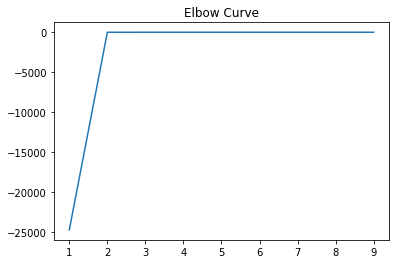

In [28]:
# First implementation for K-means with sklearn 
# (using Euclidean distance without normalization)
from sklearn.cluster import KMeans;
import matplotlib.pyplot as pl
n = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in n]
kmeans
score = [kmeans[i].fit(transformed_data).score(transformed_data) for i in range(len(kmeans))]
print(score)
pl.plot(n,score)
pl.title('Elbow Curve')
pl.show()

In [30]:
n_cluster = 2
kmeans = KMeans(n_clusters=n_cluster, init='k-means++', n_init= 20, max_iter=300, algorithm="auto")

#cluster index vector
index = kmeans.fit_predict(transformed_data)
print(index)

# Distance matrix
dist = kmeans.fit_transform(transformed_data)
print(dist)

np.unique(kmeans.labels_)

##DEBUGProcessedoutofpackages 9786
##ThreadodcsserverINFOComposetypestatedoneComposedone 213
##rootCMDusrlocalbinmonitorapachestatsshdevnull 1

# number of 1: 213
sum(i == 1 for i in kmeans.labels_)
# number of 0: 9787
sum(i == 0 for i in kmeans.labels_)

[1 1 1 ... 1 1 1]
[[1.38825097e-04 1.08903819e+01]
 [1.38825097e-04 1.08903819e+01]
 [1.38825097e-04 1.08903819e+01]
 ...
 [1.38825097e-04 1.08903819e+01]
 [1.38825097e-04 1.08903819e+01]
 [1.38825097e-04 1.08903819e+01]]


9787

In [31]:
# Second implementation for K-means with sklearn
# (Using Cosine similarity)
from nltk.cluster import KMeansClusterer
import nltk

kclusterer = KMeansClusterer(n_cluster, distance=nltk.cluster.util.cosine_distance, repeats=25, avoid_empty_clusters= True)
labels = kclusterer.cluster(transformed_data, assign_clusters=True)

##DEBUGProcessedoutofpackages 9786
##ThreadodcsserverINFOComposetypestatedoneComposedone 213
##rootCMDusrlocalbinmonitorapachestatsshdevnull 1

# number of 1: 213
sum(i == 1 for i in labels)
# number of 0: 9787
sum(i == 0 for i in labels)

9787

In [32]:
# from sompy.visualization.hitmap import HitMapView
# model.cluster(3)
# hits  = HitMapView(10,10,"Clustering",text_size=7)
# a=hits.show(model, labelsize=12)

In [33]:
# from sompy.visualization.mapview import View2D
# view2D  = View2D(10,10,"rand data",text_size=10)
# view2D.show(model, col_sz=4, which_dim="all", denormalize=True)

In [34]:
# from sompy.visualization.bmuhits import BmuHitsView

# vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
# vhts.show(model, anotate=True, onlyzeros=False, labelsize=12, cmap="Greys", logaritmic=False)

In [38]:
m = model.codebook.matrix.reshape([16, 16, transformed_data.shape[1]])

In [39]:
%qtconsole

#### Measure Distances

We want to generate some baseline summary statistics of our model

In [40]:
distances = get_anomaly_score(transformed_data, 8, m)

print(max(distances))
print(min(distances))
print(np.mean(distances))
print(np.std(distances))

0.16670965856321895
0.13826571518076092
0.1661032264563425
0.004107127067946306


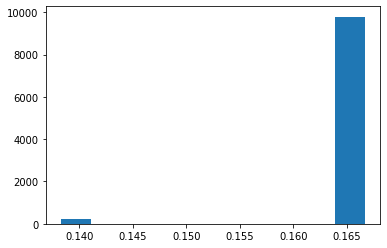

In [41]:
plt.hist(distances)
plt.show()

In [42]:
threshold = 3*np.std(distances) + np.mean(distances)
threshold

0.17842460766018142

In [43]:
threshold

0.17842460766018142

In [44]:
count = 0
for i, j in enumerate(distances):
    if j > threshold:
        print(j, data.loc[i])
        count += 1
print(count)

0


In [45]:
data.message.value_counts()

DEBUGProcessedoutofpackages                            9786
ThreadodcsserverINFOComposetypestatedoneComposedone     213
rootCMDusrlocalbinmonitorapachestatsshdevnull             1
Name: message, dtype: int64

#### Test 

In [55]:
help(infer)

Help on function infer in module __main__:

infer(w2v, som, log, data, threshold)



In [65]:
infer(w2vmodel, m, 'root CMD usr local bin monitor apache stats sh dev null', data, threshold)

(0, [0.16094855099101113])

In [66]:
infer(w2vmodel,m,'DEBUG Processed out of packages', data,threshold)

(0, [0.16670967346316967])

In [69]:
infer(w2vmodel,m,'ThreadodcsserverINFOComposetypestatedoneComposedone ', data,threshold)

(0, [0.13826575891977777])

In [70]:
infer(w2vmodel,m,'FSKSDNKSDNKSfdhfhfdhfdhfdhfdhfd  hfhf dlksfljscomLDN', data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 18175 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) t

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 94546 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 81701 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 70768 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 60635 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 53928 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 130736 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH

EPOCH - 101 : training on 10001 raw words (384 effective words) took 0.0s, 69560 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 73726 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 59356 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 89604 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 69533 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 327605 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effective 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 62639 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 47897 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 95376 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 142554 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 122044 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effective words) took 0.0s, 215763 effective words/s
worker thread finished; awaiting finish of 0 more threa

EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 118809 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 60474 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 78104 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 87059 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 68478 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effective words) took 0.0s, 63003 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 212 : training on 10001 raw words (359 effective 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 129474 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 48703 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 192404 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 57154 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effective words) took 0.0s, 97439 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 264 : training on 10001 raw words (422 effective words) took 0.0s, 61659 effective words/s
worker thread finished; awaiting finish of 0 more thread

EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 122110 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 76840 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 104524 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 91515 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effective words) took 0.0s, 141341 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 316 : training on 10001 raw words (378 effective words) took 0.0s, 272846 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 317 : training on 10001 raw words (354 effecti

worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 56013 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 64458 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 105609 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effective words) took 0.0s, 95523 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 368 : training on 10001 raw words (372 effective words) took 0.0s, 63575 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 369 : training on 10001 raw words (424 effective words) took 0.0s, 105669 effective words/s
worker thread finished; awaiting finish of 0 more thread

EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 117640 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 316181 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 95662 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effective words) took 0.0s, 79375 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 420 : training on 10001 raw words (406 effective words) took 0.0s, 119425 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 421 : training on 10001 raw words (375 effective words) took 0.0s, 97625 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 422 : training on 10001 raw words (322 effectiv

EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 93147 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 46482 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 44639 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effective words) took 0.0s, 83130 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 472 : training on 10001 raw words (386 effective words) took 0.0s, 56154 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 473 : training on 10001 raw words (372 effective words) took 0.0s, 122368 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 474 : training on 10001 raw words (355 effective 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 380349 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 399671 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effective words) took 0.0s, 92237 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 524 : training on 10001 raw words (388 effective words) took 0.0s, 158188 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 525 : training on 10001 raw words (364 effective words) took 0.0s, 151597 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 526 : training on 10001 raw words (378 effective words) took 0.0s, 65696 effective words/s
worker thread finished; awaiting finish of 0 more thre

(1, [0.3032577257514171])

In [71]:
infer(w2vmodel,m,'this is not a log message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 78241 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) t

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 54068 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 157957 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 68085 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 86626 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 79504 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 100113 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOC

worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 344174 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 408640 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 39684 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 67480 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 150203 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effective words) took 0.0s, 98367 effective words/s
worker thread finished; awaiting finish of 0 more threa

EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 55500 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 102697 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 98477 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 483708 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 51261 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effective words) took 0.0s, 63868 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 160 : training on 10001 raw words (390 effective

worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 43916 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 84619 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 60203 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 224860 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effective words) took 0.0s, 96641 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 212 : training on 10001 raw words (359 effective words) took 0.0s, 140375 effective words/s
worker thread finished; awaiting finish of 0 more thread

EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 87153 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 130319 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 118080 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 131766 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effective words) took 0.0s, 84167 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 264 : training on 10001 raw words (422 effective words) took 0.0s, 93020 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 265 : training on 10001 raw words (403 effectiv

worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 70242 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 83509 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 57099 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effective words) took 0.0s, 89056 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 316 : training on 10001 raw words (378 effective words) took 0.0s, 75311 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 317 : training on 10001 raw words (354 effective words) took 0.0s, 72248 effective words/s
worker thread finished; awaiting finish of 0 more threads


EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 290913 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 112822 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 143163 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effective words) took 0.0s, 88930 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 368 : training on 10001 raw words (372 effective words) took 0.0s, 53616 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 369 : training on 10001 raw words (424 effective words) took 0.0s, 73963 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 370 : training on 10001 raw words (393 effectiv

worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 182267 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 62374 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effective words) took 0.0s, 437675 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 420 : training on 10001 raw words (406 effective words) took 0.0s, 54524 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 421 : training on 10001 raw words (375 effective words) took 0.0s, 130683 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 422 : training on 10001 raw words (322 effective words) took 0.0s, 47383 effective words/s
worker thread finished; awaiting finish of 0 more threa

EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 263508 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 41318 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effective words) took 0.0s, 109084 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 472 : training on 10001 raw words (386 effective words) took 0.0s, 126128 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 473 : training on 10001 raw words (372 effective words) took 0.0s, 85739 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 474 : training on 10001 raw words (355 effective words) took 0.0s, 106118 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 475 : training on 10001 raw words (392 effecti

EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 115919 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 193231 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effective words) took 0.0s, 46633 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 524 : training on 10001 raw words (388 effective words) took 0.0s, 111322 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 525 : training on 10001 raw words (364 effective words) took 0.0s, 63642 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 526 : training on 10001 raw words (378 effective words) took 0.0s, 103044 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 527 : training on 10001 raw words (360 effecti

(1, [0.3072493577325832])

In [62]:
infer(w2vmodel,m,'message',data,threshold)

collecting all words and their counts
PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
collected 4 word types from a corpus of 10001 raw words and 1 sentences
Loading a fresh vocabulary
effective_min_count=1 retains 4 unique words (100% of original 4, drops 0)
effective_min_count=1 leaves 10001 word corpus (100% of original 10001, drops 0)
deleting the raw counts dictionary of 4 items
sample=0.001 downsamples 2 most-common words
downsampling leaves estimated 380 word corpus (3.8% of prior 10001)
estimated required memory for 4 words and 100 dimensions: 5200 bytes
resetting layer weights
training model with 1 workers on 4 vocabulary and 100 features, using sg=0 hs=0 sample=0.001 negative=5 window=3
worker thread finished; awaiting finish of 0 more threads
EPOCH - 1 : training on 10001 raw words (381 effective words) took 0.0s, 364517 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 2 : training on 10001 raw words (400 effective words) 

worker thread finished; awaiting finish of 0 more threads
EPOCH - 49 : training on 10001 raw words (386 effective words) took 0.0s, 158127 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 50 : training on 10001 raw words (416 effective words) took 0.0s, 87475 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 51 : training on 10001 raw words (397 effective words) took 0.0s, 78304 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 52 : training on 10001 raw words (396 effective words) took 0.0s, 76038 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 53 : training on 10001 raw words (408 effective words) took 0.0s, 88459 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 54 : training on 10001 raw words (395 effective words) took 0.0s, 79646 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH

worker thread finished; awaiting finish of 0 more threads
EPOCH - 102 : training on 10001 raw words (388 effective words) took 0.0s, 75570 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 103 : training on 10001 raw words (391 effective words) took 0.0s, 94182 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 104 : training on 10001 raw words (391 effective words) took 0.0s, 63840 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 105 : training on 10001 raw words (368 effective words) took 0.0s, 425770 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 106 : training on 10001 raw words (395 effective words) took 0.0s, 105984 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 107 : training on 10001 raw words (398 effective words) took 0.0s, 135698 effective words/s
worker thread finished; awaiting finish of 0 more threa

worker thread finished; awaiting finish of 0 more threads
EPOCH - 154 : training on 10001 raw words (361 effective words) took 0.0s, 625894 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 155 : training on 10001 raw words (358 effective words) took 0.0s, 259768 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 156 : training on 10001 raw words (369 effective words) took 0.0s, 114712 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 157 : training on 10001 raw words (394 effective words) took 0.0s, 64723 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 158 : training on 10001 raw words (367 effective words) took 0.0s, 80713 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 159 : training on 10001 raw words (347 effective words) took 0.0s, 76151 effective words/s
worker thread finished; awaiting finish of 0 more threa

EPOCH - 206 : training on 10001 raw words (386 effective words) took 0.0s, 136662 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 207 : training on 10001 raw words (361 effective words) took 0.0s, 91294 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 208 : training on 10001 raw words (361 effective words) took 0.0s, 108055 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 209 : training on 10001 raw words (364 effective words) took 0.0s, 120805 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 210 : training on 10001 raw words (347 effective words) took 0.0s, 62595 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 211 : training on 10001 raw words (381 effective words) took 0.0s, 253095 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 212 : training on 10001 raw words (359 effecti

worker thread finished; awaiting finish of 0 more threads
EPOCH - 259 : training on 10001 raw words (355 effective words) took 0.0s, 80560 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 260 : training on 10001 raw words (386 effective words) took 0.0s, 74398 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 261 : training on 10001 raw words (379 effective words) took 0.0s, 123745 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 262 : training on 10001 raw words (352 effective words) took 0.0s, 74831 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 263 : training on 10001 raw words (352 effective words) took 0.0s, 148355 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 264 : training on 10001 raw words (422 effective words) took 0.0s, 89857 effective words/s
worker thread finished; awaiting finish of 0 more thread

EPOCH - 311 : training on 10001 raw words (392 effective words) took 0.0s, 124921 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 312 : training on 10001 raw words (397 effective words) took 0.0s, 77722 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 313 : training on 10001 raw words (362 effective words) took 0.0s, 85935 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 314 : training on 10001 raw words (382 effective words) took 0.0s, 92232 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 315 : training on 10001 raw words (418 effective words) took 0.0s, 105853 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 316 : training on 10001 raw words (378 effective words) took 0.0s, 166281 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 317 : training on 10001 raw words (354 effectiv

EPOCH - 363 : training on 10001 raw words (386 effective words) took 0.0s, 136389 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 364 : training on 10001 raw words (381 effective words) took 0.0s, 89661 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 365 : training on 10001 raw words (374 effective words) took 0.0s, 103581 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 366 : training on 10001 raw words (409 effective words) took 0.0s, 132939 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 367 : training on 10001 raw words (357 effective words) took 0.0s, 63328 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 368 : training on 10001 raw words (372 effective words) took 0.0s, 81317 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 369 : training on 10001 raw words (424 effectiv

worker thread finished; awaiting finish of 0 more threads
EPOCH - 416 : training on 10001 raw words (400 effective words) took 0.0s, 50324 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 417 : training on 10001 raw words (371 effective words) took 0.0s, 50673 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 418 : training on 10001 raw words (373 effective words) took 0.0s, 85686 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 419 : training on 10001 raw words (389 effective words) took 0.0s, 101573 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 420 : training on 10001 raw words (406 effective words) took 0.0s, 100408 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 421 : training on 10001 raw words (375 effective words) took 0.0s, 77321 effective words/s
worker thread finished; awaiting finish of 0 more thread

EPOCH - 468 : training on 10001 raw words (335 effective words) took 0.0s, 105052 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 469 : training on 10001 raw words (373 effective words) took 0.0s, 129418 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 470 : training on 10001 raw words (364 effective words) took 0.0s, 134173 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 471 : training on 10001 raw words (398 effective words) took 0.0s, 81373 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 472 : training on 10001 raw words (386 effective words) took 0.0s, 97590 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 473 : training on 10001 raw words (372 effective words) took 0.0s, 110171 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 474 : training on 10001 raw words (355 effecti

worker thread finished; awaiting finish of 0 more threads
EPOCH - 521 : training on 10001 raw words (402 effective words) took 0.0s, 94875 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 522 : training on 10001 raw words (396 effective words) took 0.0s, 66283 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 523 : training on 10001 raw words (361 effective words) took 0.0s, 86009 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 524 : training on 10001 raw words (388 effective words) took 0.0s, 106414 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 525 : training on 10001 raw words (364 effective words) took 0.0s, 80226 effective words/s
worker thread finished; awaiting finish of 0 more threads
EPOCH - 526 : training on 10001 raw words (378 effective words) took 0.0s, 63596 effective words/s
worker thread finished; awaiting finish of 0 more threads

(1, [0.30671534616395946])